# TP0 - Toxic Comments
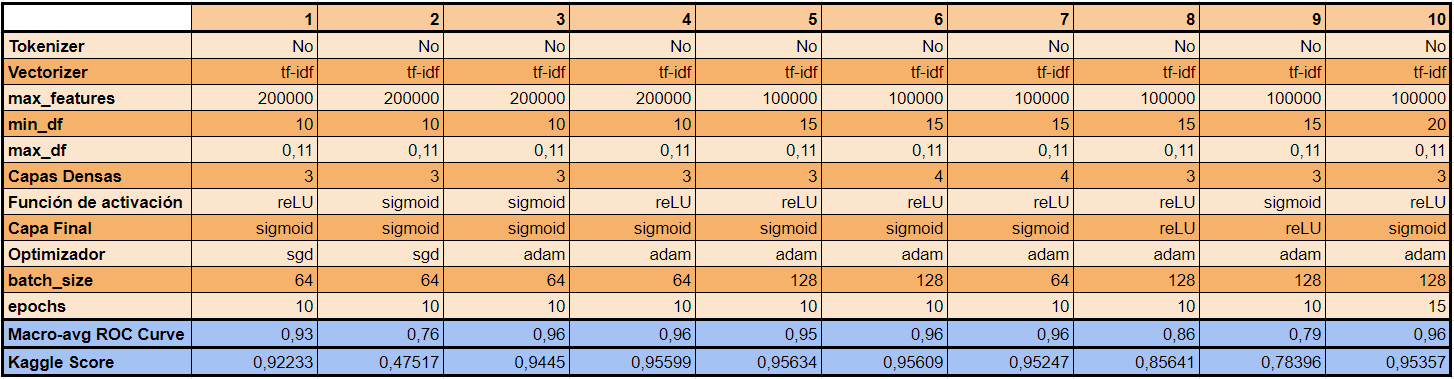

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np

import os

# Lemmatizer

In [27]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

# Stemming


In [28]:
from nltk.stem.porter import PorterStemmer
import re
token_pattern=r"(?u)\b\w\w+\b"
compiled_reg_exp = re.compile(token_pattern)
def StemTokenizer(text):
    tokens = compiled_reg_exp.findall(text)
    stems = []
    for item in tokens:
        if len(item)>100:
            item = 'tooLongWord'
        stems.append(PorterStemmer().stem(item))
    return stems

# Open dataset and split into Train set and Validate set
Para las pruebas, se utiliza el método de Hold-Out. Este método consiste en separar el dataset en dos partes, una para entrenar el modelo, y otra para validar el modelo. Dependiendo la cantidad de datos en el dataset, suele emplearse una división de 80% training y 20% testing, pero para datasets mayores se puede utilizar un porcentaje de training mayor.
Otro metodo que podría utilizarse es el 'cross-validation' o 'k-folding'. Este metodo consiste en dividir el dataset en k partes iguales ('folds'), usar k-1 para entrenar y el que sobra para validar. Luego, se itera el proceso k veces, donde en cada iteración el fold de validación es diferente.
K-folding suele ser el mejor para entrenar un modelo y que el mismo se encuentre bien preparado frente a entradas desconocidas. Pero, debido a que hace el proceso de entrenamiento y validación k veces, resulta muy intensivo de recursos y tiempo. Es por eso que para datasets muy grandes, hold-out es más útil, ya que le permite desarrollar un modelo con un dataset muy grande en menos tiempo.

In [29]:
# Dataset
folder = '/kaggle/input/jigsaw-toxic-comment-classification-challenge/'
train = pd.read_csv(folder+"train.csv.zip")
test = pd.read_csv(folder+"test.csv.zip")
submission = pd.read_csv(folder+"sample_submission.csv.zip")

list_classes = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
y = train[list_classes].values

# Split
X_train, X_valid, Y_train, Y_valid = train_test_split(train, y, test_size = 0.1)

# Raw datasets
raw_text_train = X_train["comment_text"].str.lower()
raw_text_valid = X_valid["comment_text"].str.lower()
raw_text_test = test["comment_text"].str.lower()

# Vectorize

Para realizar la vectorización, se podría hacer a través de count vectorizer o tf-idf vectorizer. Por un lado, count vectorizer separa las palabras por la frecuencia de ocurrencia. Es una manera simple de ordenar las palabras para entender el contenido de un dataset con base en cuáles son las palabras comunes. Igualmente, count vectorizer tiene ciertas limitaciones. Por ejemplo, asume que las palabras más frecuentes son las más importantes, cuando necesariamente no es ese el caso. También, es incapaz de determinar la importancia de las palabras en sí, ya que se basa solo en la frecuencia de ocurrencia. Y finalmente, no reconoce las similitudes y relaciones que pueden tener las palabras.
Es por eso que se tiene el term frequency–inverse document frequency, o tf-idf, vectorizer. El objetivo de tfidf es no solamente ordenar las palabras por frecuencia de ocurrencia, sino también por su importancia. El proceso se puede dividir en dos partes, la parte tf, y la parte idf. La parte tf, o 'term frequency' funciona similar al count vectorizer, ya que ordena las palabras por su frecuencia de ocurrencia relatva, es decir, dentro de cada documento particular. Mientras tanto, el idf, o 'inverse document frecuency', nos determina la importancia de cada palabra basándose en que tanta información nos provee. En particular, se estima la cantidad de información de cada palabra en relación con la inversa de su frecuencia de ocurrencia, es decir, cuanto menos veces ocurra la palabra, se obtiene más información.
Es decir, la importancia se define como un balance entre que tantas veces ocurre una palabra con poca ocurrencia. Se puede decir entonces que tf-idf determina que una palabra dentro de un documento es importante si se utiliza muchas veces en un documento, pero pocas veces en todos los documentos. De esta manera, puede corregir las limitaciones del count vectorizer, ya que se puede estimar la importancia de cada palabra más allá de su frecuencia de ocurrencia.

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

max_features = 100000

tokenizer = LemmaTokenizer()

tfidf_vectorizer = TfidfVectorizer(max_df=0.11, min_df=15,
                                   max_features=max_features,
                                   #tokenizer=StemTokenizer,
                                   #tokenizer=tokenizer,
                                   stop_words='english'
                                  )

%time tfidf_matrix_train = tfidf_vectorizer.fit_transform(raw_text_train)

In [31]:
%time tfidf_matrix_valid = tfidf_vectorizer.transform(raw_text_valid)

In [32]:
%time tfidf_matrix_test = tfidf_vectorizer.transform(raw_text_test)

# Bag of Words
Luego de realizar la vectorización, lo que se obtiene es el 'bag of words' de cada documento. El bag of words es una simplificación del texto de entrada, en la que no se tiene en cuenta la gramatica, sino que solo importan las palabras y su ocurrencia. Se le llama 'bag' of words porque a fin y a cabo el texto de entrada se resume a un simple conjunto de palabras desjuntas, en vez de tener la oración que conformaban. Es un sistema muy simple de simplificar una gran cantidad de información, sobre la cual se puede luego especificar basándose en la aplicación necesaria, por lo que lo hace un modelo muy versátil para Natural Language Processing. Igualmente, en casos donde sea importante el contexto de la oración, bag of words puede verse limitado, ya que el orden en el que se encuentran las palabras nos podría dar información que se perdería al armar el bag of words.

# Reducción de Dimensionalidad

In [33]:
from sklearn.decomposition import TruncatedSVD

trunSVD = TruncatedSVD(n_components=300)
%time dense_matrix_train = trunSVD.fit_transform(tfidf_matrix_train)

In [34]:
%time dense_matrix_valid = trunSVD.transform(tfidf_matrix_valid)

In [35]:
dense_matrix_train.shape, dense_matrix_valid.shape

In [36]:
%time dense_matrix_test = trunSVD.transform(tfidf_matrix_test)

# Train Model

In [37]:
from keras.models import Sequential
from keras import optimizers
from keras.layers.core import Dense, Activation

In [38]:
input_features = dense_matrix_train.shape[1]
output_size = Y_train.shape[1]

model = Sequential()
model.add(Dense(100, activation = 'relu', input_dim=input_features, name='Capa_Oculta_1'))
model.add(Dense(100, activation = 'relu', name='Capa_Oculta_2'))
model.add(Dense(50, activation = 'relu', name='Capa_Oculta_3'))
model.add(Dense(output_size, activation = 'sigmoid',name='Capa_Final'))

In [39]:
model.summary()

In [40]:
model.compile(loss='binary_crossentropy', optimizer = 'adam')

In [41]:
batch_size = 128
epochs = 10

model.fit(dense_matrix_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(dense_matrix_valid, Y_valid))

# Predict

In [42]:
pred_test = model.predict(dense_matrix_test, verbose = 1)

In [43]:
submission[list_classes] = pred_test
submission.to_csv("submission_model.csv", index = False)

# Evaluate

In [44]:
pred_valid = model.predict(dense_matrix_valid, verbose = 1)
pred_train = model.predict(dense_matrix_train, verbose = 1)

In [45]:
model.evaluate(dense_matrix_valid, Y_valid)

# Predict for Test

In [46]:
pred = model.predict(dense_matrix_test, verbose=1)

In [47]:
submission[list_classes] = pred
submission.to_csv("submission_test.csv", index = False)

# ROC Curve
Para evaluar la exactitud del modelo, se emplea el metodo ROC-AUC. Ya que se esta tratando de un sistema de clasificación binario (si un documento pertenece o no a ciertas categorias), se puede entonces determinar una taza de verdaderos positivos y falsos positivos. A esto se le llama 'Reciever Operating Characteristic', o ROC. A partir de esto, se puede pensar en la taza de falsos positivos en el eje x, y de verdaderos positivos en el eje y, por lo que se obtiene la condición ideal de 100% verdaderos positivos. Entonces, se espera que al mover el umbral de elección entre verdadero o falso para una clasificación, nos acerquemos más al ideal. Es por eso que se obtiene el 'Area Under Curve' o AUC, que será mayor por mas cerca al ideal que se encuentre una clasificación.
Luego, ya que se tienen varias clasificaciones posibles, se puede obtener un promedio de los ROC-AUC obtenidos. Este promedio puede ser teniendo en cuenta la importancia de cada clasificación por si misma, es decir, la cantidad de ocurrencia de cada clasificación en el dataset que se esta evaluando (micro-average), o tomando a todas las clasificaciones con el mismo peso (macro-average).
Otra manera de determinar la exactitud del modelo es F1-score. A diferencia del ROC-AUC, F1-score no solo considera la taza de verdaderos positivos (también conocida como 'recall'), sino que en vez de considerar la taza de falsos positivos, considera la taza de aciertos ('precision'), definida como la cantidad de verdaderos positivos sobre la suma de verdaderos positivos y falsos positivos.
Ya que F1 considera la importancia de la precisión de verdaderos positivos obtenida, esta misma suele recomendarse cuando se le da más importancia a la obtención correcta de positivos. Si tanto los positivos como negativos son importantes, se recomienda ROC-AUC. También, F1-score es mejor que ROC-AUC cuando se tiene un dataset altamente inbalanceado, ya que para ROC-AUC, la taza de falsos positivos decae al tener más verdaderos negativos.

In [48]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

print(roc_auc_score(Y_train, pred_train, average='macro'))
print(roc_auc_score(Y_valid, pred_valid, average='macro'))

In [49]:
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = Y_valid.shape[1]
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_valid[:, i], pred_valid[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
fpr["micro"], tpr["micro"], _ = roc_curve(Y_valid.ravel(), pred_valid.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [50]:
from matplotlib import pyplot as plt
# Compute macro-average ROC curve and ROC area
lw = 2
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()